In [1]:
import os
from PIL import Image
from torch.utils.data import Dataset
import torchvision.transforms as transforms

class HairRemovalDataset(Dataset):
    def __init__(self, hair_dir, clean_dir, transform=None):
        self.hair_dir = hair_dir
        self.clean_dir = clean_dir
        self.transform = transform

        self.hair_images = sorted([f for f in os.listdir(hair_dir) if f.endswith('.jpg')])
        self.clean_images = sorted([f for f in os.listdir(clean_dir) if f.endswith('.jpg')])
        assert len(self.hair_images) == len(self.clean_images), "图像数量不匹配"

    def __len__(self):
        return len(self.hair_images)

    def __getitem__(self, idx):
        hair_img = Image.open(os.path.join(self.hair_dir, self.hair_images[idx])).convert("RGB")
        clean_img = Image.open(os.path.join(self.clean_dir, self.clean_images[idx])).convert("RGB")

        if self.transform:
            hair_img = self.transform(hair_img)
            clean_img = self.transform(clean_img)

        return hair_img, clean_img


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super(UNet, self).__init__()

        def conv_block(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, 3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_c, out_c, 3, padding=1),
                nn.ReLU(inplace=True)
            )

        self.down1 = conv_block(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)

        self.down2 = conv_block(64, 128)
        self.pool2 = nn.MaxPool2d(2)

        self.bridge = conv_block(128, 256)

        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.up_block2 = conv_block(256, 128)

        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.up_block1 = conv_block(128, 64)

        self.out = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        d1 = self.down1(x)
        p1 = self.pool1(d1)

        d2 = self.down2(p1)
        p2 = self.pool2(d2)

        bridge = self.bridge(p2)

        up2 = self.up2(bridge)
        concat2 = torch.cat([up2, d2], dim=1)
        u2 = self.up_block2(concat2)

        up1 = self.up1(u2)
        concat1 = torch.cat([up1, d1], dim=1)
        u1 = self.up_block1(concat1)

        return self.out(u1)


Epoch 1/20, Loss: 0.3325
Epoch 2/20, Loss: 0.0567
Epoch 3/20, Loss: 0.0136
Epoch 4/20, Loss: 0.0106
Epoch 5/20, Loss: 0.0095
Epoch 6/20, Loss: 0.0087
Epoch 7/20, Loss: 0.0078
Epoch 8/20, Loss: 0.0068
Epoch 9/20, Loss: 0.0053
Epoch 10/20, Loss: 0.0039
Epoch 11/20, Loss: 0.0032
Epoch 12/20, Loss: 0.0031
Epoch 13/20, Loss: 0.0026
Epoch 14/20, Loss: 0.0024
Epoch 15/20, Loss: 0.0022
Epoch 16/20, Loss: 0.0019
Epoch 17/20, Loss: 0.0016
Epoch 18/20, Loss: 0.0015
Epoch 19/20, Loss: 0.0014
Epoch 20/20, Loss: 0.0013


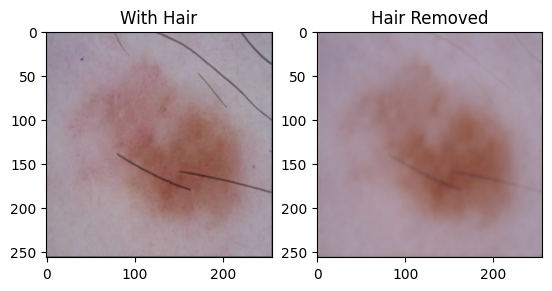

In [3]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms

# 训练参数
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

# 数据加载
dataset = HairRemovalDataset(
    hair_dir='/root/autodl-fs/skin_hair_dataset/alignment/photo with hair',
    clean_dir='/root/autodl-fs/skin_hair_dataset/alignment/oryginal',
    transform=transform
)
train_loader = DataLoader(dataset, batch_size=4, shuffle=True)

# 模型与优化器
model = UNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.MSELoss()

# 训练循环
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for hair_img, clean_img in train_loader:
        hair_img, clean_img = hair_img.to(device), clean_img.to(device)

        pred = model(hair_img)
        loss = criterion(pred, clean_img)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/len(train_loader):.4f}")
# 保存模型
torch.save(model.state_dict(), 'u_net_hair_removal.pth')

# 测试
model.eval()
with torch.no_grad():
    sample_input, _ = dataset[0]
    sample_input = sample_input.unsqueeze(0).to(device)
    output = model(sample_input).cpu().squeeze().permute(1, 2, 0)

    import matplotlib.pyplot as plt
    plt.subplot(1, 2, 1)
    plt.imshow(sample_input.cpu().squeeze().permute(1, 2, 0))
    plt.title("With Hair")
    plt.subplot(1, 2, 2)
    plt.imshow(output.clamp(0, 1))
    plt.title("Hair Removed")
    plt.show()


In [11]:
import cv2
import numpy as np
from skimage.metrics import mean_squared_error, peak_signal_noise_ratio, structural_similarity
from sewar.full_ref import uqi
from PIL import Image
import matplotlib.pyplot as plt

# ---------- 指标计算函数 ----------
def calculate_metrics(pred_img, gt_img):
    pred_img = pred_img.astype(np.float32) / 255.0
    gt_img = gt_img.astype(np.float32) / 255.0

    h, w = pred_img.shape[:2]
    win_size = min(7, h, w)
    if win_size % 2 == 0:
        win_size -= 1

    mse = mean_squared_error(gt_img, pred_img)
    psnr = peak_signal_noise_ratio(gt_img, pred_img, data_range=1.0)
    ssim = structural_similarity(gt_img, pred_img, data_range=1.0, channel_axis=2, win_size=win_size)
    uqi_val = uqi(gt_img, pred_img)

    return mse, psnr, ssim, uqi_val

# ---------- 批量评估 ----------
model.load_state_dict(torch.load('u_net_hair_removal.pth'))
model.eval()

test_hair_dir = '/root/autodl-fs/skin_hair_dataset/alignment/photo with hair'
test_clean_dir = '/root/autodl-fs/skin_hair_dataset/alignment/oryginal'
test_images = sorted([f for f in os.listdir(test_hair_dir) if f.endswith('.jpg')])

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

total_mse, total_psnr, total_ssim, total_uqi = 0, 0, 0, 0

print("\n📊 Evaluation Metrics for Image-to-Image UNet Hair Removal:\n")

for img_name in test_images:  # 可调整数量或遍历全部
    # 加载带毛发图和无毛发图
    hair_img = Image.open(os.path.join(test_hair_dir, img_name)).convert('RGB')
    clean_img = Image.open(os.path.join(test_clean_dir, img_name)).convert('RGB')

    hair_tensor = transform(hair_img).unsqueeze(0).to(device)

    with torch.no_grad():
        pred = model(hair_tensor).cpu().squeeze().permute(1, 2, 0).numpy()

    pred = (pred * 255).clip(0, 255).astype(np.uint8)
    gt = np.array(clean_img.resize((256, 256)))

    mse, psnr, ssim, uqi_val = calculate_metrics(pred, gt)

    print(f"{img_name} → MSE: {mse:.4f}, PSNR: {psnr:.2f}, SSIM: {ssim:.4f}, UQI: {uqi_val:.4f}")

    total_mse += mse
    total_psnr += psnr
    total_ssim += ssim
    total_uqi += uqi_val

# ---------- 平均结果 ----------
n = len(test_images)
print("\n📈 Average Metrics (Direct Regression UNet):")
print(f"Avg MSE: {total_mse / n:.4f}")
print(f"Avg PSNR: {total_psnr / n:.2f}")
print(f"Avg SSIM: {total_ssim / n:.4f}")
print(f"Avg UQI: {total_uqi / n:.4f}")


/tmp/ipykernel_1643/3565778655.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('u_net_hair_removal.pth'))



📊 Evaluation Metrics for Image-to-Image UNet Hair Removal:

ISIC2017_0000026.jpg → MSE: 0.0006, PSNR: 32.41, SSIM: 0.9311, UQI: 0.9992
ISIC2017_0000081.jpg → MSE: 0.0004, PSNR: 33.51, SSIM: 0.8732, UQI: 0.9992
ISIC2017_0000082.jpg → MSE: 0.0012, PSNR: 29.16, SSIM: 0.8939, UQI: 0.9892
ISIC2017_0000147.jpg → MSE: 0.0017, PSNR: 27.61, SSIM: 0.8082, UQI: 0.9947
ISIC2017_0000150.jpg → MSE: 0.0008, PSNR: 31.19, SSIM: 0.8684, UQI: 0.9949
ISIC2017_0000151.jpg → MSE: 0.0011, PSNR: 29.40, SSIM: 0.8979, UQI: 0.9916
ISIC2017_0000152.jpg → MSE: 0.0012, PSNR: 29.38, SSIM: 0.8486, UQI: 0.9918
ISIC2017_0000153.jpg → MSE: 0.0013, PSNR: 28.85, SSIM: 0.8411, UQI: 0.9962
ISIC2017_0000154.jpg → MSE: 0.0008, PSNR: 30.77, SSIM: 0.8448, UQI: 0.9972
ISIC2017_0001148.jpg → MSE: 0.0008, PSNR: 31.20, SSIM: 0.8863, UQI: 0.9969
ISIC2017_0012137.jpg → MSE: 0.0013, PSNR: 28.81, SSIM: 0.8229, UQI: 0.9962
ISIC2017_0015079.jpg → MSE: 0.0011, PSNR: 29.64, SSIM: 0.8013, UQI: 0.9591
ISIC2019_0000171.jpg → MSE: 0.0022, PSN